It is necessary to mounnt your Google Drive to access the pima diabetes dataset






In [1]:
from google.colab import drive
drive.mount('/content/drive')
!cd "/content/drive/My Drive/RanDonnees"

Mounted at /content/drive


# Machine Learning intermediate

Dataset used for this worhsop : https://www.kaggle.com/uciml/pima-indians-diabetes-database

Full description of the dataset : https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.names


Aim : Binary classification : diabete / non-diabete

The main topic of this workshop is to build a pipeline from scratch using different classifiers (SVMs, logicitic regression, KNNs, Decision Trees, AdaBoost, GradientBoosting and more). 

Let's start with data loading, exploration & preprocessing


In [43]:
# Python libraries

# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

# Importation and colab stuff
import os
from google.colab import drive

# Graphical tools to make representations easy
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns

# Data hygiene

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb


# Metrics and ML processing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


#Storing the dataset into a Panda DataFrame

In [3]:
#Storage of the dataset into a Pandas dataframe
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
#Let's look at the first 10 rows
diabetesDF.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#Quick look at the data

In [4]:
#More infos on the dataset using pandas's method info
diabetesDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#Importance of random state

In [5]:
#Make your work reproducible and comparable
rs = 43
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=rs, stratify=y)
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
400,4,95,64,0,0,32.0,0.161,31
724,1,111,94,0,0,32.8,0.265,45
196,1,105,58,0,0,24.3,0.187,21
417,4,144,82,32,0,38.5,0.554,37
767,1,93,70,31,0,30.4,0.315,23


#Missing values ?

In [32]:
#Esimating missing values
#Note : you should never encode your missing values using zeros
#Replace 0 values by NaN. This is necessary for further imputation methods
diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    = diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    .replace(0,np.NaN)

In [33]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)
    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)
# Plotting 
missing_plot(diabetesDF,'Outcome')

##
# Question : should I remove sample with missing data ?
##

#Another way to look at the correlation using seaborn

It is essential to look at the datas (hope you don't have thousands of features -> feature selection)



*   It could help you to see which features may be able to split your dataset into diabetic and non-diaabetic
*   Help you to figure out colinearities
*   Help you to see missing datas



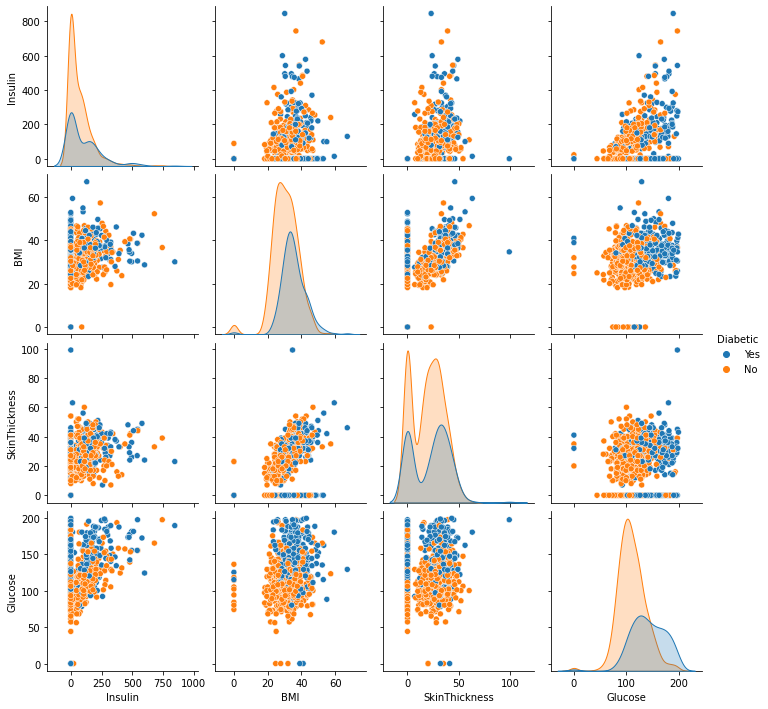

In [8]:
#Change the numerical outcomes by a string
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
map_dict = {1: "Yes", 0: "No"}
diabetesDF['Outcome'] = diabetesDF['Outcome'].map(map_dict)
diabetesDF.rename(columns={'Outcome':'Diabetic'}, inplace=True)
sub = diabetesDF[['Insulin','BMI','SkinThickness','Glucose','Diabetic']]
sns.pairplot(sub, hue = "Diabetic")
#sns.pairplot(diabetesDF, hue = "Diabetic")

#What does it looks like after imputation of missing data ?

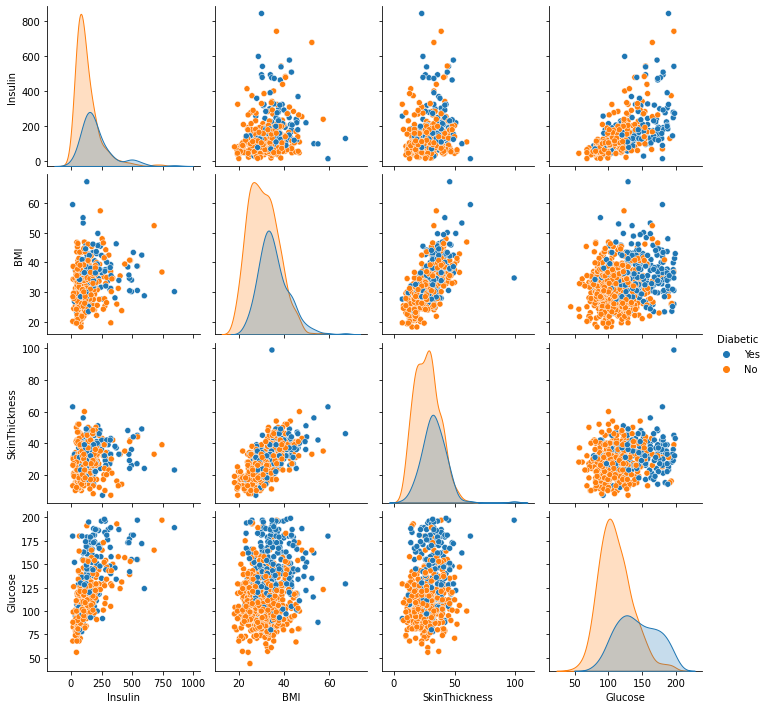

In [9]:
#Change the numerical outcomes by a string
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    = diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    .replace(0,np.NaN)
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
imputer = IterativeImputer(random_state=rs)
imputed = imputer.fit_transform(X)
map_dict = {1: "Yes", 0: "No"}
diabetesDF['Outcome'] = diabetesDF['Outcome'].map(map_dict)
diabetesDF.rename(columns={'Outcome':'Diabetic'}, inplace=True)
sub = diabetesDF[['Insulin','BMI','SkinThickness','Glucose','Diabetic']]
sns.pairplot(sub, hue = "Diabetic")
#sns.pairplot(diabetesDF, hue = "Diabetic")

#Is the dataset unbalanced ?

In [10]:
#Unbalanced Data ?
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
trace = go.Pie(labels = ['healthy','diabetic'], values = diabetesDF['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))
layout = dict(title =  'Distribution of Outcome variable')
fig = dict(data = [trace], layout=layout)
py.iplot(fig)
#
## Very simple non-graphic command : diabetesDF.groupby(['Outcome']).size()
#
## What are the consequeces of unbalanced data ? 
#
## Please take a look at subsampling and oversampling methods :
#
# https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

#The basic commands to train a model ?

* Split Outcomes and Features
* Split the data into train and set (.train_split)
* Train the model on the train set (.fit)
* Test the performance of the trainde model on the unseen test data (.predict) 
* Calculate accuracy (or any metrics) on the training and test steps




In [11]:
# Splitting Features & Outcomes

diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]

# Splitting datasets into training & test sets
# Stratified by Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/10, random_state=rs, stratify=y)
print('Train size : {} / Test size : {}'.format(X_train.shape,X_test.shape))

#Instance of the classifier
clf = LogisticRegression(max_iter = 1000, random_state= rs)
#Training on the train set
clf.fit(X_train,y_train)
#Prediction of Outcomes
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#Calculation of accuracy and F1 scores on the training and test sets
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)

#Print the results
print('Acc_train : {} / Acc_test : {}'.format(accuracy_train, accuracy_test))

Train size : (691, 8) / Test size : (77, 8)
Acc_train : 0.7800289435600579 / Acc_test : 0.8051948051948052


#Let's add the confusion matrix to see what's going on


Train size : (614, 8) / Test size : (154, 8)
Acc_train : 0.7785016286644951 / Acc_test : 0.7922077922077922


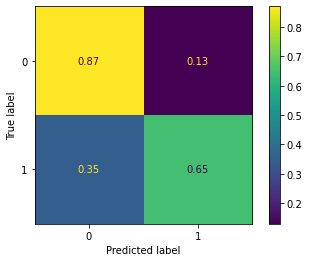

In [12]:
# Splitting Features & Outcomes

diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]

# Splitting datasets into training & test sets
# Startified by Outcome

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=rs, stratify=y)
print('Train size : {} / Test size : {}'.format(X_train.shape,X_test.shape))
#Instance of tehe classifier
clf = LogisticRegression(max_iter = 1000, random_state=43)
#Training on the train set
clf.fit(X_train,y_train)
#Prediction of Outcomes
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
#Calculation of accuracy and F1 scores on the training and test sets
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
#Print the results
print('Acc_train : {} / Acc_test : {}'.format(accuracy_train, accuracy_test))
#Plot the confusion matrix
#cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
# I love the next representation more : normalized by "True Label"

cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_, normalize='true')
ConfusionMatrixDisplay(cm,display_labels=clf.classes_).plot()


#Quick look at Decision Trees

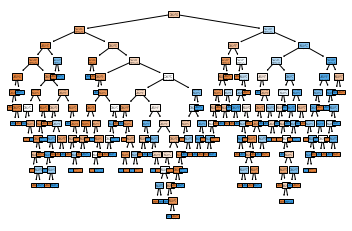

#Let's compare different models

In [14]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
##
# Note : try to change the test_size
##
basic_models=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
for model in models:
    model.fit(X_train,y_train)
    prediction_train=model.predict(X_train)
    prediction_test=model.predict(X_test)
    myresults = [metrics.accuracy_score(prediction_train,y_train), metrics.accuracy_score(prediction_test,y_test)]
    basic_models.append(myresults)
models_dataframe_BM=pd.DataFrame(basic_models,index=classifiers)   
models_dataframe_BM.columns=['BM Training Accuracy','BM Test Accuracy']
models_dataframe_BM

,BM Training Accuracy,BM Test Accuracy
Linear Svm,0.772793,0.805195
Radial Svm,0.767004,0.792208
Logistic Regression,0.780029,0.805195
KNN,0.811867,0.714286
Decision Tree,1.000000,0.766234


#Imputation of missing data using mean or median



In [15]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    = diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    .replace(0,np.NaN)
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
##
#
##
#imputer = SimpleImputer(strategy='mean')
imputer = IterativeImputer(random_state=rs)
#imputer = KNNImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
for model in models:
    model.fit(X_train,y_train)
    prediction_train=model.predict(X_train)
    prediction_test=model.predict(X_test)
    myresults = [metrics.accuracy_score(prediction_train,y_train), metrics.accuracy_score(prediction_test,y_test)]
    abc.append(myresults)
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Training Accuracy','Test Accuracy']
df_full = pd.concat([models_dataframe.reset_index(drop=True), models_dataframe_BM.reset_index(drop=True)], axis=1)
df_full.index = classifiers
df_full

,Training Accuracy,Test Accuracy,BM Training Accuracy,BM Test Accuracy
Linear Svm,0.764110,0.805195,0.772793,0.805195
Radial Svm,0.755427,0.779221,0.767004,0.792208
Logistic Regression,0.768452,0.805195,0.780029,0.805195
KNN,0.804631,0.701299,0.811867,0.714286
Decision Tree,1.000000,0.805195,1.000000,0.766234


#Standardization / Normalization of datas

In [16]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
##
#
##
#sc = StandardScaler()
sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
for model in models:
    model.fit(X_train_scaled,y_train)
    prediction_train=model.predict(X_train_scaled)
    prediction_test=model.predict(X_test_scaled)
    myresults = [metrics.accuracy_score(prediction_train,y_train), metrics.accuracy_score(prediction_test,y_test)]
    abc.append(myresults)
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Training Accuracy','Test Accuracy']
df_full = pd.concat([models_dataframe.reset_index(drop=True), models_dataframe_BM.reset_index(drop=True)], axis=1)
df_full.index = classifiers
df_full

,Training Accuracy,Test Accuracy,BM Training Accuracy,BM Test Accuracy
Linear Svm,0.771346,0.805195,0.772793,0.805195
Radial Svm,0.803184,0.766234,0.767004,0.792208
Logistic Regression,0.775687,0.792208,0.780029,0.805195
KNN,0.807525,0.766234,0.811867,0.714286
Decision Tree,1.000000,0.766234,1.000000,0.766234


#PCA-based feature selection

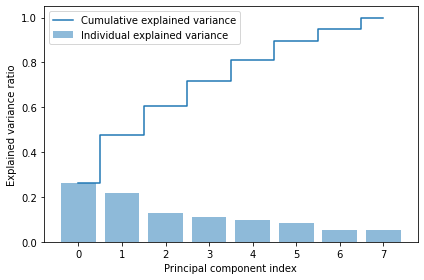

In [17]:
#PCA explained variance calculation
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
##
#
##
pca = PCA()
X = StandardScaler().fit_transform(X)
principalComponents = pca.fit_transform(X)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()
#print(exp_var_pca)

In [18]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
##
#
##
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
abc=[]
pca = PCA(n_components=3)
# try to change the number of components
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)
#X_train_PCA.shape
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
for model in models:
    model.fit(X_train_PCA,y_train)
    prediction_train=model.predict(X_train_PCA)
    prediction_test=model.predict(X_test_PCA)
    myresults = [metrics.accuracy_score(prediction_train,y_train), metrics.accuracy_score(prediction_test,y_test)]
    abc.append(myresults)
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Training Accuracy','Test Accuracy']
df_full = pd.concat([models_dataframe.reset_index(drop=True), models_dataframe_BM.reset_index(drop=True)], axis=1)
df_full.index = classifiers
df_full

,Training Accuracy,Test Accuracy,BM Training Accuracy,BM Test Accuracy
Linear Svm,0.727931,0.792208,0.772793,0.805195
Radial Svm,0.759768,0.766234,0.767004,0.792208
Logistic Regression,0.727931,0.792208,0.780029,0.805195
KNN,0.804631,0.753247,0.811867,0.714286
Decision Tree,1.000000,0.688312,1.000000,0.766234


#Univariate feature selection (SelectKBest)


In [19]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
meth_feat_select= SelectKBest(score_func=f_classif, k=4)
feat_select =  meth_feat_select.fit(X_train, y_train)
X_train_SelectKBest = feat_select.transform(X_train)
X_test_SelectKBest = feat_select.transform(X_test)
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
for model in models:
    model.fit(X_train_SelectKBest,y_train)
    prediction_train=model.predict(X_train_SelectKBest)
    prediction_test=model.predict(X_test_SelectKBest)
    myresults = [metrics.accuracy_score(prediction_train,y_train), metrics.accuracy_score(prediction_test,y_test)]
    abc.append(myresults)
models_dataframe=pd.DataFrame(abc,index=classifiers)   
models_dataframe.columns=['Training Accuracy','Test Accuracy']
df_full = pd.concat([models_dataframe.reset_index(drop=True), models_dataframe_BM.reset_index(drop=True)], axis=1)
df_full.index = classifiers
df_full

,Training Accuracy,Test Accuracy,BM Training Accuracy,BM Test Accuracy
Linear Svm,0.762663,0.831169,0.772793,0.805195
Radial Svm,0.769899,0.805195,0.767004,0.792208
Logistic Regression,0.764110,0.831169,0.780029,0.805195
KNN,0.817656,0.805195,0.811867,0.714286
Decision Tree,1.000000,0.571429,1.000000,0.766234


#Which features have been selected?

In [83]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rs, stratify=y)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
meth_feat_select= SelectKBest(score_func=f_classif, k=4)
feat_select =  meth_feat_select.fit(X_train, y_train)
myres = pd.concat([pd.DataFrame(feat_select.pvalues_), pd.DataFrame(feat_select.scores_)], axis = 1)
myres.columns = ['pvalue','score']
myres.index = diabetesDF.columns[0:8]
myres.sort_values(by=['score'],ascending=False)

,pvalue,score
Glucose,3.144487e-37,183.466291
BMI,1.416531e-14,61.876007
Age,3.823552e-09,35.627194
Pregnancies,6.671745e-08,29.805540
DiabetesPedigreeFunction,1.504137e-06,23.553075
Insulin,1.375301e-03,10.322611
SkinThickness,3.814887e-02,4.314946
BloodPressure,7.288875e-02,3.226604


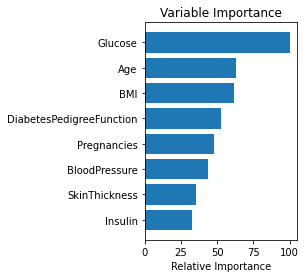

In [21]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
clf = ExtraTreesClassifier(n_estimators=250,
                              random_state=rs)
clf.fit(X_train, y_train)
# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#K-fold cross-validation : how well a model will perform in a real world application ?


In [22]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
ns = 10
kf = StratifiedKFold(n_splits=ns, shuffle = True, random_state = rs)
for model in models:
  result = cross_val_score(model , X, y, cv = kf)
  temp = []
  for el in result:
    temp.append(el)
  temp.append(result.mean())
  temp.append(result.std())
  abc.append(temp)
models_dataframe=pd.DataFrame(abc,index=classifiers) 

liste_Acc = []
for i in range(1,ns + 1):
  Ac = 'Acc ' + str(i)
  liste_Acc.append(Ac)
liste_Acc.append('Mean CV Acc')
liste_Acc.append('std CV Acc')

models_dataframe.columns= liste_Acc
models_dataframe
df_full = pd.concat([models_dataframe.reset_index(drop=True), models_dataframe_BM['BM Test Accuracy'].reset_index(drop=True)], axis=1)
df_full.index = classifiers
df_full

,Acc 1,Acc 2,Acc 3,Acc 4,Acc 5,Acc 6,Acc 7,Acc 8,Acc 9,Acc 10,Mean CV Acc,std CV Acc,BM Test Accuracy
Linear Svm,0.714286,0.766234,0.766234,0.844156,0.792208,0.818182,0.792208,0.740260,0.802632,0.644737,0.768113,0.054354,0.805195
Radial Svm,0.714286,0.779221,0.740260,0.831169,0.779221,0.792208,0.779221,0.740260,0.750000,0.657895,0.756374,0.045248,0.792208
Logistic Regression,0.714286,0.766234,0.753247,0.857143,0.792208,0.844156,0.792208,0.740260,0.815789,0.671053,0.774658,0.054802,0.805195
KNN,0.662338,0.727273,0.701299,0.792208,0.727273,0.701299,0.740260,0.701299,0.710526,0.697368,0.716114,0.032489,0.714286
Decision Tree,0.688312,0.688312,0.766234,0.818182,0.675325,0.649351,0.714286,0.688312,0.763158,0.657895,0.710936,0.051680,0.766234


#A graphical version of the Kfold cross-validation

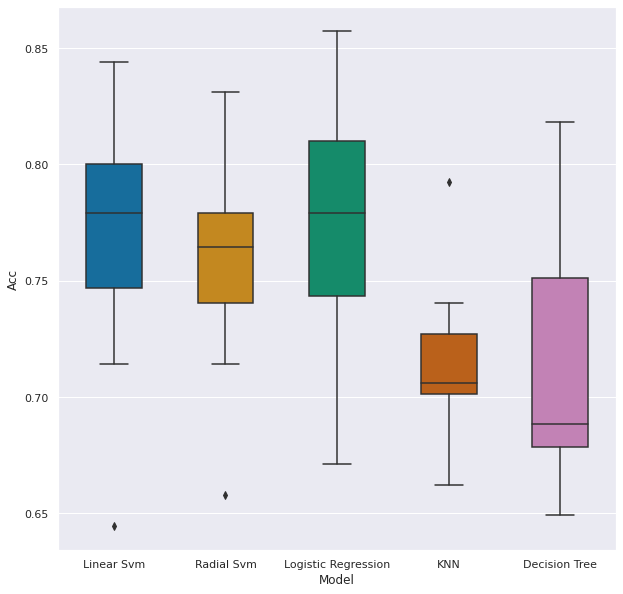

In [23]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
abc=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree']
models=[svm.SVC(kernel='linear', random_state=rs),
        svm.SVC(kernel='rbf',random_state=rs),
        LogisticRegression(max_iter= 2000, random_state=rs),
        KNeighborsClassifier(),
        DecisionTreeClassifier(random_state=rs)
        ]
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rs)
models_line = []
values_line = []
ind = 0
for model in models:
  result = cross_val_score(model , X, y, cv = kf)
  for el in result:
    name = str(model)
    models_line.append(classifiers[ind])
    values_line.append(el)
  ind += 1
df = pd.DataFrame(list(zip(models_line, values_line)),columns =['Model', 'Acc'])
sns.set(rc = {'figure.figsize':(10,10)})
sns.boxplot(y='Acc', x='Model', data=df,width=0.5,palette="colorblind")

#Some words abour decision trees and explainability

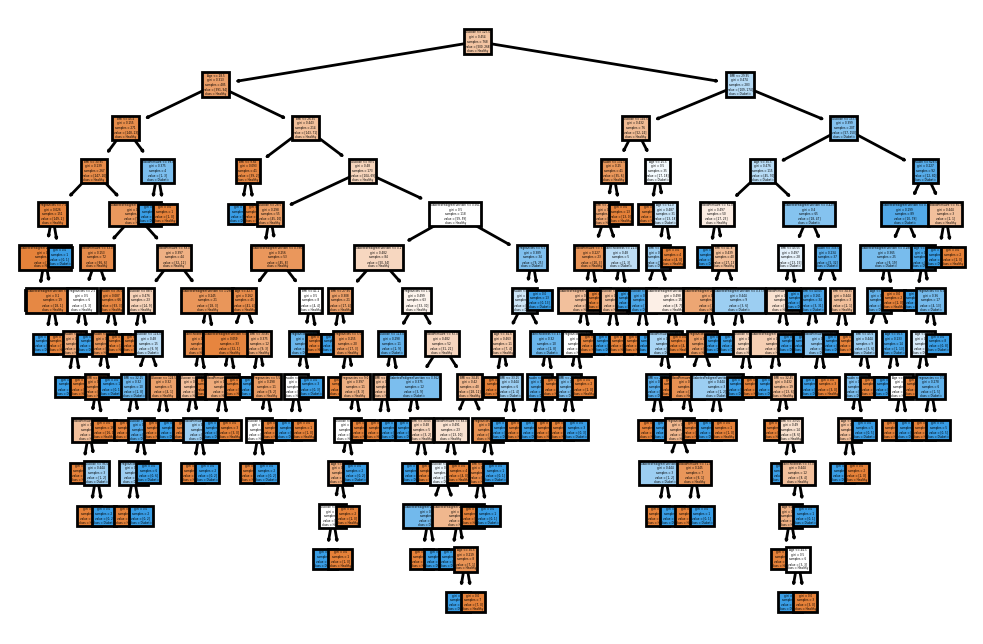

In [37]:
#Explainable AI
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from matplotlib.pyplot import figure

diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF.iloc[:,:-1]
y = diabetesDF.iloc[:,-1]
figure(figsize=(6, 4), dpi=200)
clf = DecisionTreeClassifier(max_depth = None).fit(X,y)
plot_tree(clf,
          feature_names = diabetesDF.columns, 
          class_names=['Healthy','Diabetic'],
          filled = True)
plt.show()

#Tree-based ensemble methods


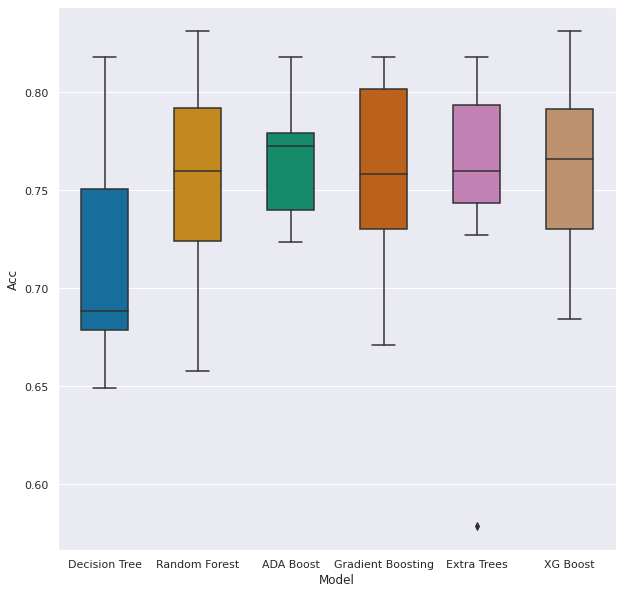

In [ ]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
abc=[]
classifiers=['Decision Tree','Random Forest', 'ADA Boost', 'Gradient Boosting', 'Extra Trees','XG Boost']
models=[DecisionTreeClassifier(random_state=rs),
        RandomForestClassifier(random_state=rs),
        AdaBoostClassifier(random_state=rs),
        GradientBoostingClassifier(random_state=rs),
        ExtraTreesClassifier(random_state=rs),
        xgb.XGBClassifier(random_state=rs)
        ]
kf = StratifiedKFold(n_splits=10, shuffle = True, random_state = rs)
models_line = []
values_line = []
ind = 0
for model in models:
  result = cross_val_score(model , X, y, cv = kf)
  for el in result:
    models_line.append(classifiers[ind])
    values_line.append(el)
  ind += 1
df = pd.DataFrame(list(zip(models_line, values_line)),columns =['Model', 'Acc'])
sns.set(rc = {'figure.figsize':(10,10)})
sns.boxplot(y='Acc', x='Model', data=df,width=0.5,palette="colorblind")

#Why ensemble methods are powerfull ?

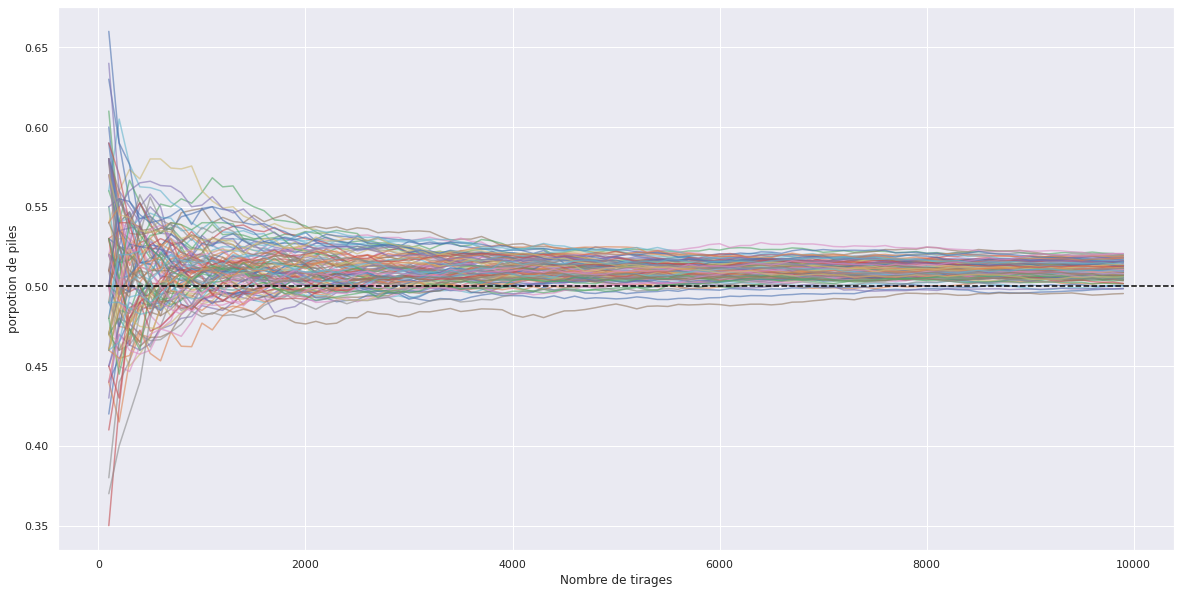

In [24]:
from scipy.stats import bernoulli
p = 0.51
col = [i for i in np.arange(100, 10000 , 100)]
lines = []
for n in range(0,100):
  res = []
  line = []
  for i in range(100,10000,100):
    r = bernoulli.rvs(p,size=100)
    res.extend(r.tolist())
    ratio = res.count(1) / len(res)
    line.append(ratio)
  lines.append(line)
results = pd.DataFrame(lines , columns= col)
ax = results.T.plot(figsize=(20, 10),legend=None, alpha=0.6)
ax.set_ylabel('porpotion de piles', fontsize=12)
ax.set_xlabel('Nombre de tirages', fontsize=12)
plt.axhline(y=0.5, color='black', linestyle='--')
plt.show()

#Quick look at the wonderful Pipeline library 
https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html




*   GridSearchSVM in action


In [ ]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
pipe = Pipeline([('sc', StandardScaler()),
                 ('SVM',svm.SVC(random_state = rs))
])
#parameters for grid search
params = {'SVM__C': [0.1, 1],
              'SVM__gamma': [1, 0.1]}
#Find the best model through grid search
grid = GridSearchCV(estimator = pipe,
                      param_grid = params,
                      cv = 5,
                      return_train_score=True, verbose=3) 
grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END SVM__C=0.1, SVM__gamma=1;, score=(train=0.652, test=0.647) total time=   0.0s
[CV 2/5] END SVM__C=0.1, SVM__gamma=1;, score=(train=0.651, test=0.652) total time=   0.0s
[CV 3/5] END SVM__C=0.1, SVM__gamma=1;, score=(train=0.651, test=0.652) total time=   0.0s
[CV 4/5] END SVM__C=0.1, SVM__gamma=1;, score=(train=0.651, test=0.652) total time=   0.0s
[CV 5/5] END SVM__C=0.1, SVM__gamma=1;, score=(train=0.651, test=0.652) total time=   0.0s
[CV 1/5] END SVM__C=0.1, SVM__gamma=0.1;, score=(train=0.745, test=0.719) total time=   0.0s
[CV 2/5] END SVM__C=0.1, SVM__gamma=0.1;, score=(train=0.779, test=0.761) total time=   0.0s
[CV 3/5] END SVM__C=0.1, SVM__gamma=0.1;, score=(train=0.734, test=0.754) total time=   0.0s
[CV 4/5] END SVM__C=0.1, SVM__gamma=0.1;, score=(train=0.769, test=0.717) total time=   0.0s
[CV 5/5] END SVM__C=0.1, SVM__gamma=0.1;, score=(train=0.770, test=0.739) total time=   0.0s
[CV 1/5] END SVM__C=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('SVM', SVC(random_state=43))]),
             param_grid={'SVM__C': [0.1, 1], 'SVM__gamma': [1, 0.1]},
             return_train_score=True, verbose=3)



*   Selecting the best hyperparameters



In [25]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
pipe = Pipeline([('sc', StandardScaler()),
                 ('SVM',svm.SVC(random_state = rs))
])
#parameters for grid search
params = {'SVM__C': [0.1, 1],
              'SVM__gamma': [1, 0.1],
              'SVM__kernel': ['rbf','linear']}
#Please try to modify kernels
#SVM__kernel': [‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’]
#Find the best model through grid search
grid = GridSearchCV(estimator = pipe,
                      param_grid = params,
                      cv = 5,
                      return_train_score=True) 
grid.fit(X_train, y_train)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
y_test_pred = grid.predict(X_test)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test,y_test)))
myresults.sort_values(by=['mean_validation_score'], ascending=False)
# Take a look at the results
#print('Test score = {}'.format(grid.score(X_test,y_test)))
#for k,v in grid.cv_results_.items():
#  print(k,v)#



Score : 0.7742258367219268
Parameters :{'SVM__C': 0.1, 'SVM__gamma': 1, 'SVM__kernel': 'linear'}
Final Test score :0.8051948051948052




,SVM__C,SVM__gamma,SVM__kernel,mean_train_score,std_train_score,mean_validation_score,std_validation_score
1,0.1,1.0,linear,0.776411,0.010758,0.774226,0.043882
3,0.1,0.1,linear,0.776411,0.010758,0.774226,0.043882
5,1.0,1.0,linear,0.774963,0.011308,0.768429,0.041866
7,1.0,0.1,linear,0.774963,0.011308,0.768429,0.041866
6,1.0,0.1,rbf,0.816569,0.009214,0.762632,0.035210
2,0.1,0.1,rbf,0.759401,0.017081,0.738088,0.017539
4,1.0,1.0,rbf,0.963819,0.003446,0.688823,0.020950
0,0.1,1.0,rbf,0.651230,0.000472,0.651236,0.001877




*   A more complexe GridSearch



In [ ]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
pipe = Pipeline([('sc', StandardScaler()),
                 ('SVM',svm.SVC(random_state = rs))
])
#parameters for grid search
params = {'SVM__C': [0.001, 0.01, 0.1, 1, 10],
          'SVM__gamma': [0.001, 0.01, 0.1, 1],
          'SVM__kernel': ['linear', 'poly','rbf', 'sigmoid']}
#Find the best model through grid search
grid = GridSearchCV(estimator = pipe,
                      param_grid = params,
                      cv = 5,
                      n_jobs= -1,
                      return_train_score=True) 
grid.fit(X_train, y_train)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test,y_test)))
myresults.sort_values(by=['mean_validation_score'], ascending=False).head()



Score : 0.7742466896048378
Parameters :{'SVM__C': 10, 'SVM__gamma': 0.001, 'SVM__kernel': 'rbf'}
Final Test score :0.8181818181818182




,SVM__C,SVM__gamma,SVM__kernel,mean_train_score,std_train_score,mean_validation_score,std_validation_score
66,10.0,0.001,rbf,0.774605,0.009194,0.774247,0.036445
40,0.1,0.100,linear,0.776411,0.010758,0.774226,0.043882
36,0.1,0.010,linear,0.776411,0.010758,0.774226,0.043882
44,0.1,1.000,linear,0.776411,0.010758,0.774226,0.043882
32,0.1,0.001,linear,0.776411,0.010758,0.774226,0.043882




*   GridSearch Validation score distribution



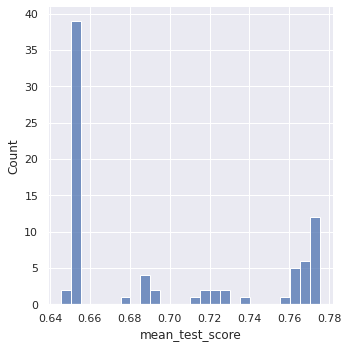

In [ ]:
res_df = pd.DataFrame({'mean_test_score': grid.cv_results_['mean_test_score']})
sns.displot(data=res_df, x='mean_test_score',binwidth=0.005)

To go further into best model selection, please take a look at : 
https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

Note : statistics are Not dead

#Adding a feature selection

In [26]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
pipe = Pipeline([('sc', StandardScaler()),
                 ('KB',SelectKBest(score_func=f_classif)),
                 ('SVM',svm.SVC(random_state = rs))])
#parameters for grid search
params = {'SVM__C': [ 0.1, 1, 10],
          'SVM__gamma': [0.01, 0.1, 1],
          'SVM__kernel': ['linear'],
          'KB__k' : [1,2,3,4,5,6]
          }
#Find the best model through grid search
grid = GridSearchCV(estimator = pipe,
                      param_grid = params,
                      cv = 10,
                      n_jobs= -1,
                      return_train_score=True) 
grid.fit(X_train, y_train)
myresults = pd.concat([pd.DataFrame(grid.cv_results_["params"]),
                       pd.DataFrame(grid.cv_results_["mean_train_score"],columns=["mean_train_score"]),
                       pd.DataFrame(grid.cv_results_["std_train_score"],columns=["std_train_score"]),
                       pd.DataFrame(grid.cv_results_["mean_test_score"],columns=["mean_validation_score"]),
                       pd.DataFrame(grid.cv_results_["std_test_score"], columns=["std_validation_score"])],axis=1)
print('\n\nScore : {}\nParameters :{}\nFinal Test score :{}\n\n'.format(grid.best_score_, grid.best_params_,grid.score(X_test,y_test)))
myresults.sort_values(by=['mean_validation_score'], ascending=False).head()



Score : 0.7670600414078674
Parameters :{'KB__k': 3, 'SVM__C': 0.1, 'SVM__gamma': 0.01, 'SVM__kernel': 'linear'}
Final Test score :0.8181818181818182




,KB__k,SVM__C,SVM__gamma,SVM__kernel,mean_train_score,std_train_score,mean_validation_score,std_validation_score
20,3,0.1,1.00,linear,0.764592,0.005290,0.767060,0.038177
19,3,0.1,0.10,linear,0.764592,0.005290,0.767060,0.038177
18,3,0.1,0.01,linear,0.764592,0.005290,0.767060,0.038177
22,3,1.0,0.10,linear,0.764753,0.004283,0.765611,0.034341
23,3,1.0,1.00,linear,0.764753,0.004283,0.765611,0.034341


#Can we get a better score with ensemble methods ?

In [ ]:
steps = [('KB',SelectKBest(score_func=f_classif)),('ETC', ExtraTreesClassifier())]
pipeline = Pipeline(steps) # define the pipeline object
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
max_depth = np.linspace(2, 40, 4)
params = { 
    "ETC__n_estimators": [200,400,600],
    "ETC__max_depth": max_depth,
    "KB__k" : [2,3,4,5,6]
}
grid = GridSearchCV(pipeline, param_grid=params, cv=10,n_jobs=-1)
grid.fit(X_train, y_train)
print('Test score = {}'.format(grid.score(X_test,y_test)))
print(grid.best_params_)

#Using 'passthrough' to skip some steps

In [ ]:
steps = [('Imputation',SimpleImputer()),
         ('scaler', StandardScaler()),
         ('feature_select' , SelectKBest()),
         ('SVM', svm.SVC())]
pipeline = Pipeline(steps)
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    = diabetesDF[['Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']]\
    .replace(0,np.NaN)
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
grid = {'Imputation__strategy' : ['mean','median'],
        'feature_select' : [ 'passthrough',SelectKBest(k=2),SelectKBest(k=3),SelectKBest(k=4),SelectKBest(k=5)],
        'SVM__gamma': [1, 0.1, 0.01, 0.001, 0.0001],
        'SVM__kernel': ['rbf','linear']
        }
grid = GridSearchCV(pipeline, param_grid=grid, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
print('Test score = {}'.format(grid.score(X_test,y_test)))
print(grid.best_params_)
res_df = pd.DataFrame({'mean_test_score': grid.cv_results_['mean_test_score']})

Test score = 0.8051948051948052
{'Imputation__strategy': 'mean', 'SVM__gamma': 1, 'SVM__kernel': 'linear', 'feature_select': SelectKBest(k=5)}


#Finals steps : re-training your model & storing parameters

*   Parameters :{'KB__k': 4, 'SVM__C': 1, 'SVM__gamma': 0.01, 'SVM__kernel': 'linear'}
*   Final Test score 0.83



In [96]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
scaler = StandardScaler()
X = scaler.fit_transform(X)
final_clf = svm.SVC(C = 1, gamma = 0.01,kernel = "linear",probability=True)
final_clf.fit(X,y)
final_clf.get_params()

{'C': 1,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 0.01,
 'kernel': 'linear',
 'max_iter': -1,
 'probability': True,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [97]:
import pickle
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
filename = 'finalized_model_diabetes.sav'
pickle.dump(final_clf, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8051948051948052


#Predicting outcome for a new patient

In [98]:
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]

new_patient = {'Pregnancies' : 7, 'Glucose' : 50, 'BloodPressure' : 50, 'SkinThickness' : 24, 'Insulin' : 153,
       'BMI' : 30, 'DiabetesPedigreeFunction' : 0.534, 'Age' : 45}
X_new = pd.DataFrame([new_patient], index = ['new patient'])

sc = StandardScaler()
X = sc.fit_transform(X)
X_new = sc.transform(X_new)

#classifier = LogisticRegression(random_state=rs, penalty='none')
#classifier.fit(X, y)
y_new_patient = loaded_model.predict(X_new)
print(loaded_model, y_new_patient)

SVC(C=1, gamma=0.01, kernel='linear', probability=True) [0]


#Probability of the prediction

In [99]:
proba_new_patient = loaded_model.predict_proba(X_new)
print(classifier, y_new_patient, proba_new_patient)

LogisticRegression(penalty='none', random_state=43) [0] [[0.94202218 0.05797782]]


#Last words about Multilayer Perceptrons ?

In [ ]:
from sklearn.neural_network import MLPClassifier
steps = [('scaler', StandardScaler()),
         ('KB',SelectKBest(score_func=f_classif, k = 4)),
         ('MLP', MLPClassifier(random_state=rs))]
pipeline = Pipeline(steps) 
diabetesDF = pd.read_csv("/content/drive/My Drive/RanDonnees/diabetes.csv")
X = diabetesDF[diabetesDF.columns[0:8]]
y = diabetesDF[diabetesDF.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1, random_state=rs, stratify=y)
params  = [
    {'MLP__solver': ['adam'],
     'MLP__learning_rate_init': [0.0001],
     'MLP__max_iter': [10000],
      'MLP__hidden_layer_sizes': [(10,20,20,10), (20,50,50,20), (50,100,100,50)],
     'MLP__activation': ['tanh'],
     'MLP__alpha': [0.0001, 0.001, 0.05],
     'MLP__early_stopping': [False]
     }
]
grid = GridSearchCV(pipeline, param_grid=params, cv=5,n_jobs=-1)
grid.fit(X_train, y_train)
print('Test score = {}'.format(grid.score(X_test,y_test)))
print(grid.best_params_)
res_df = pd.DataFrame({'mean_test_score': grid.cv_results_['mean_test_score']})

Test score = 0.8311688311688312
{'MLP__activation': 'tanh', 'MLP__alpha': 0.0001, 'MLP__early_stopping': False, 'MLP__hidden_layer_sizes': (10, 20, 20, 10), 'MLP__learning_rate_init': 0.0001, 'MLP__max_iter': 10000, 'MLP__solver': 'adam'}
